# Walsh Comparison: 1950s-70s

In [1]:
import sys,os,copy
import numpy as np
import pickle

from scipy import stats
from scipy import signal
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [2]:
sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/instrumental_assimilation_experiments/')
import reanalysis_recons_utils as rrutils

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/')
import commonera_utils as ce_utils 

sys.path.insert(1,'/home/disk/kalman2/mkb22/LMR_lite/')
import LMR_utils as lmr

Loading information from datasets.yml
Loading information from grid_def.yml
Loading information from datasets.yml
Loading information from grid_def.yml


In [18]:
plt.rcParams['figure.dpi']=200

In [3]:
def sub_arctic_plot(fig,ax,VAR1,LAT,LON,TITLE1,MAX1,colorbar=True,extent=True):
    var1, lon1 = add_cyclic_point(VAR1, coord=LON)
    new_lon2d, new_lat2d = np.meshgrid(lon1, LAT)
    if extent is True: 
        ax.set_extent([-150, 140, 50, 90], crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--')
    ax.add_feature(cfeature.LAND, facecolor=(1,1,1))
    cs = ax.pcolormesh(new_lon2d, new_lat2d, var1, 
                       vmin=-MAX1, vmax=MAX1, cmap=plt.cm.RdBu_r, 
                       transform=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', linewidth=0.5)
    if colorbar is True:
        plt.colorbar(cs, ax=ax)
    ax.set_title(TITLE1)
    
    return cs

In [4]:
proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                          central_longitude=-45,
                                          true_scale_latitude=0.1))

In [5]:
def load_ccsm4_lm_regridded():
    ccsm4_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/CCSM4/CCSM4_last_millennium/'
    ccsm4_file = 'ccsm4_sic_sit_tas_20CRv2_850_1850_full.npz'

    ccsm4_lm = np.load(ccsm4_dir+ccsm4_file)

    ccsm4_truth_sic = ccsm4_lm['sic_ccsm4']
    ccsm4_truth_sit = ccsm4_lm['sit_ccsm4']
    ccsm4_truth_tas = ccsm4_lm['tas_ccsm4']
    ccsm4_truth_lat = ccsm4_lm['lat_ccsm4']
    ccsm4_truth_lon = ccsm4_lm['lon_ccsm4']
    
    return ccsm4_truth_tas, ccsm4_truth_sic, ccsm4_truth_sit, ccsm4_truth_lat, ccsm4_truth_lon

In [6]:
anom_start=1979
anom_end = 2000

## Load/preprocess Walsh et al. 2019 spatial data: 

In [7]:
# LOAD ANNUAL WALSH DATA: 
walsh_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/Walsh2016/G10010_SIBT1850_V2/'
walsh_filename = 'G10010_sibt1850_v2.0.nc'

walsh_ds = xr.open_dataset(walsh_dir+walsh_filename)
walsh_landmask = np.where((walsh_ds.LandRegion_mask.values<20)&(walsh_ds.LandRegion_mask.values<21),1.0,0)

walsh_sic_annual = walsh_ds.seaice_conc.groupby('time.year').mean(dim=['time'])
#walsh_sic_satmn = walsh_sic_annual.sel(year=slice('1979','2000'))

walsh_sic_annual_anom = walsh_sic_annual - walsh_sic_annual.sel(year=slice('1979','2000')).mean(dim='year')

In [91]:
walsh_sic_50_70 = walsh_sic_annual_anom.sel(year=slice('1950','1965'))
walsh_sie = np.where(walsh_sic_50_70>=15.0,100,0)
walsh_sie_50_70_mn = np.nanmean(walsh_sie,axis=0)

walsh_lat_2d = np.ones((240,1440))*walsh_ds.latitude.values[:,np.newaxis]
walsh_lon_2d = np.ones((240,1440))*walsh_ds.longitude.values[np.newaxis,:]

# Regrid full tas prior for proxy selection and verification: 
[walsh_sie_50_70_mn_rg,rg_lat,rg_lon] = lmr.regrid_esmpy(91,180,1,np.reshape(walsh_sie_50_70_mn,(240*1440,1)),
                                                         walsh_lat_2d,walsh_lon_2d,
                                                         240,1440,method='bilinear')

walsh_sie_50_70_mn_rg = np.reshape(walsh_sie_50_70_mn_rg,(91,180))

## Load/preprocess reconstructions spatial data: 

In [9]:
output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/ccsm4/'
#output_file_ccsm4 = 'sic_ccsm4_anrecon_0_2000_pages2kv2_inf2_6_loc15000_iter0.pkl'
output_file_ccsm4 = 'sic_ccsm4_anrecon_revisions1_0_2000_pages2kv2_inf2_6_loc15000_iter0.pkl'

niter = 10

[sic_lalo_allit_ccsm4, tas_lalo_allit_ccsm4, sic_ens_var_allit_ccsm4, 
 nobs_allit_ccsm4, sia_ens_allit_ccsm4, sie_ens_allit_ccsm4, Ye_assim_allit_ccsm4, 
 Ye_assim_coords_allit_ccsm4, Xb_inflate_allit_ccsm4, recon_years, 
 proxy_assim_loc_allit_ccsm4] = ce_utils.load_recon_allit(output_dir_ccsm4,output_file_ccsm4,niter)

In [10]:
output_dir_mpi = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/mpi/'
#output_file_mpi = 'sic_mpi_anrecon_0_2000_pages2kv2_inf1_8_loc15000_iter0.pkl'
output_file_mpi = 'sic_mpi_anrecon_revisions1_0_2000_pages2kv2_inf1_8_loc15000_iter0.pkl'

[sic_lalo_allit_mpi, tas_lalo_allit_mpi, sic_ens_var_allit_mpi, 
 nobs_allit_mpi, sia_ens_allit_mpi, sie_ens_allit_mpi, Ye_assim_allit_mpi, 
 Ye_assim_coords_allit_mpi, Xb_inflate_allit_mpi, recon_years, 
 proxy_assim_loc_allit_mpi] = ce_utils.load_recon_allit(output_dir_mpi,output_file_mpi,niter)

In [11]:
[ccsm4_truth_tas, ccsm4_truth_sic, 
 ccsm4_truth_sit,
 ccsm4_truth_lat, ccsm4_truth_lon] = load_ccsm4_lm_regridded()

ccsm4_truth_time = np.arange(850,1851,1)

In [93]:
sic_lalo_allit_mpi_anom = sic_lalo_allit_mpi - np.nanmean(sic_lalo_allit_mpi[1979:2000,:,:,:],axis=0)
sic_lalo_allit_ccsm4_anom = sic_lalo_allit_ccsm4 - np.nanmean(sic_lalo_allit_ccsm4[1979:2000,:,:,:],axis=0)

sic_mpi_lalo = np.reshape(np.moveaxis(sic_lalo_allit_mpi_anom[1950:1966,:,:,:],3,0),(160,91,180))
sic_ccsm4_lalo = np.reshape(np.moveaxis(sic_lalo_allit_ccsm4_anom[1950:1966,:,:,:],3,0),(160,91,180))

sie_mpi_lalo = np.where(sic_mpi_lalo>=15.0,100,0)
sie_ccsm4_lalo = np.where(sic_ccsm4_lalo>=15.0,100,0)

sie_ccsm4_50_70_mn = np.nanmean(sie_ccsm4_lalo,axis=0)
sie_mpi_50_70_mn = np.nanmean(sie_mpi_lalo,axis=0)

In [97]:
nharea = 2*np.pi*(6380**2)/1e8

_,nhmic,_ = lmr.global_hemispheric_means(walsh_sie_50_70_mn_rg,ccsm4_truth_lat[:,0])
walsh_mn = nhmic*nharea

_,nhmic,_ = lmr.global_hemispheric_means(sie_ccsm4_50_70_mn,ccsm4_truth_lat[:,0])
ccsm4_recon_mn = nhmic*nharea

_,nhmic,_ = lmr.global_hemispheric_means(sie_mpi_50_70_mn,ccsm4_truth_lat[:,0])
mpi_recon_mn = nhmic*nharea

## Plot differences: 

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Text(270,40,'Recon-CCSM4,Pages2kv2 mean = 0.22 x 10$^{6}$ $km^2$')

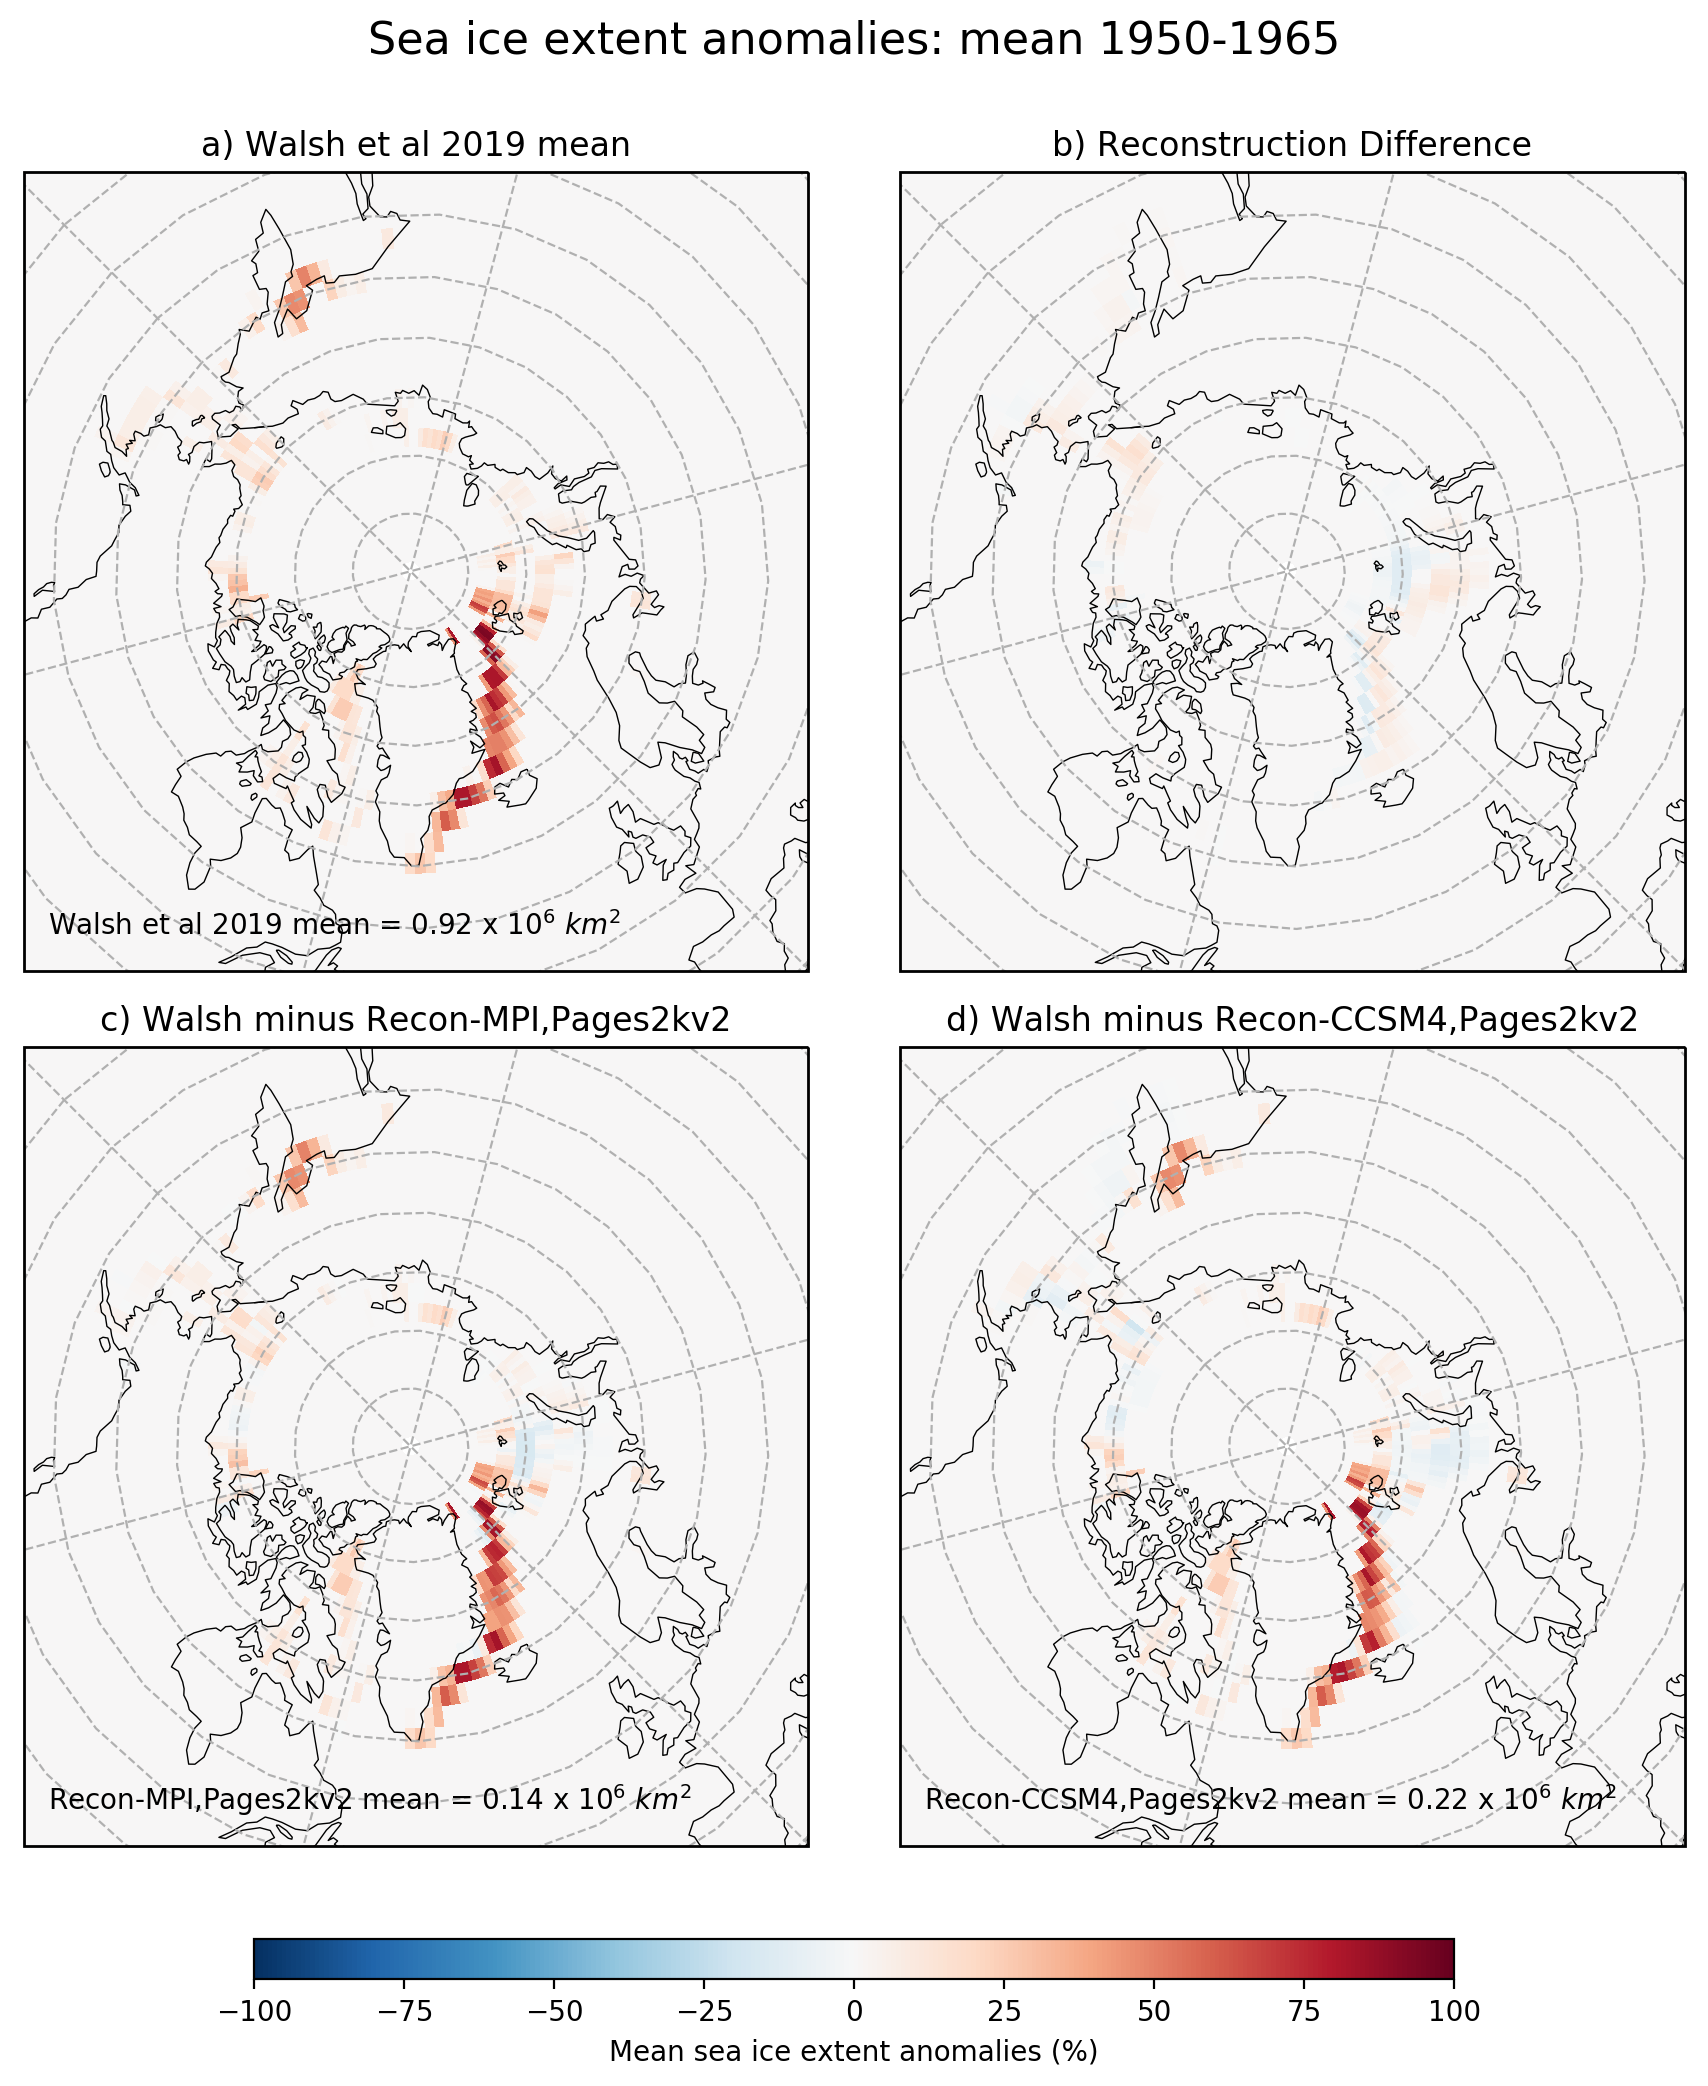

In [213]:
fig,ax = plt.subplots(2,2, figsize=(10, 10), subplot_kw = proj)
ax = ax.flatten()

cs = sub_arctic_plot(fig,ax[0],walsh_sie_50_70_mn_rg,ccsm4_truth_lat[:,0],
                     ccsm4_truth_lon[0,:],'a) Walsh et al 2019 mean',100, colorbar=False)
cs1 = sub_arctic_plot(fig,ax[3],walsh_sie_50_70_mn_rg-sie_ccsm4_50_70_mn,ccsm4_truth_lat[:,0],
                     ccsm4_truth_lon[0,:],'d) Walsh minus Recon-CCSM4,Pages2kv2',100, colorbar=False)
cs2 = sub_arctic_plot(fig,ax[2],walsh_sie_50_70_mn_rg-sie_mpi_50_70_mn,ccsm4_truth_lat[:,0],
                     ccsm4_truth_lon[0,:],'c) Walsh minus Recon-MPI,Pages2kv2',100, colorbar=False)
cs3 = sub_arctic_plot(fig,ax[1],sie_ccsm4_50_70_mn-sie_mpi_50_70_mn,ccsm4_truth_lat[:,0],
                     ccsm4_truth_lon[0,:],'b) Reconstruction Difference',100, colorbar=False)

position=fig.add_axes([0.15,0.0,0.6,0.02])
cb = plt.colorbar(cs, cax=position, orientation='horizontal', label='Mean sea ice extent anomalies (%)')

fig.suptitle('Sea ice extent anomalies: mean 1950-1965', fontsize=16, x=0.45)
plt.tight_layout(rect=(0,0.05,0.90,0.94))


ax[0].text(270,40,('Walsh et al 2019 mean = '+str(np.round(walsh_mn,2)[0])+ ' x 10$^{6}$ $km^2$'),transform=ccrs.PlateCarree())
ax[2].text(270,40,('Recon-MPI,Pages2kv2 mean = '+str(np.round(mpi_recon_mn,2)[0])+ ' x 10$^{6}$ $km^2$'),transform=ccrs.PlateCarree())
ax[3].text(270,40,('Recon-CCSM4,Pages2kv2 mean = '+str(np.round(ccsm4_recon_mn,2)[0])+ ' x 10$^{6}$ $km^2$'),transform=ccrs.PlateCarree())

# savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
#            'analysis/figures/Brennan_Hakim_2020/')
# savename = 'sat_recon_ce_corr_spatial_validation.png'
#plt.savefig(savedir+savename, bbox_inches='tight')

In [101]:
walsh_ds.seaice_source

<xarray.DataArray 'seaice_source' (time: 2016, latitude: 240, longitude: 1440)>
[696729600 values with dtype=uint8]
Coordinates:
  * latitude   (latitude) float32 89.875 89.625 89.375 ... 30.625 30.375 30.125
  * longitude  (longitude) float32 0.125 0.375 0.625 ... 359.375 359.625 359.875
  * time       (time) object 1850-01-15 00:00:00 ... 2017-12-15 00:00:00
Attributes:
    short_name:      Seaice Source
    long_name:       Coded_Source_of_Sea_Ice_Concentration
    standard_name:   source
    units:           1
    name_source_00:  Land
    name_source_01:  Satellite passive microwave
    name_source_02:  Danish Meteorological Institute
    name_source_03:  Dehn
    name_source_04:  NAVO yearbooks
    name_source_05:  AARI
    name_source_06:  Hill
    name_source_07:  Whaling Records - Complete Sea Ice
    name_source_08:  Whaling Records - Partial Sea Ice
    name_source_09:  Whaling Records - No Sea Ice
    name_source_10:  DMI yearbook narrative
    name_source_11:  ACSYS
    na

In [156]:
walsh_sources_50_70.sel(time=t).values[0,:,250:350]

array([[12, 12, 12, ..., 12, 12, 12],
       [12, 12, 12, ..., 12, 12, 12],
       [12, 12, 12, ..., 12, 12, 12],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

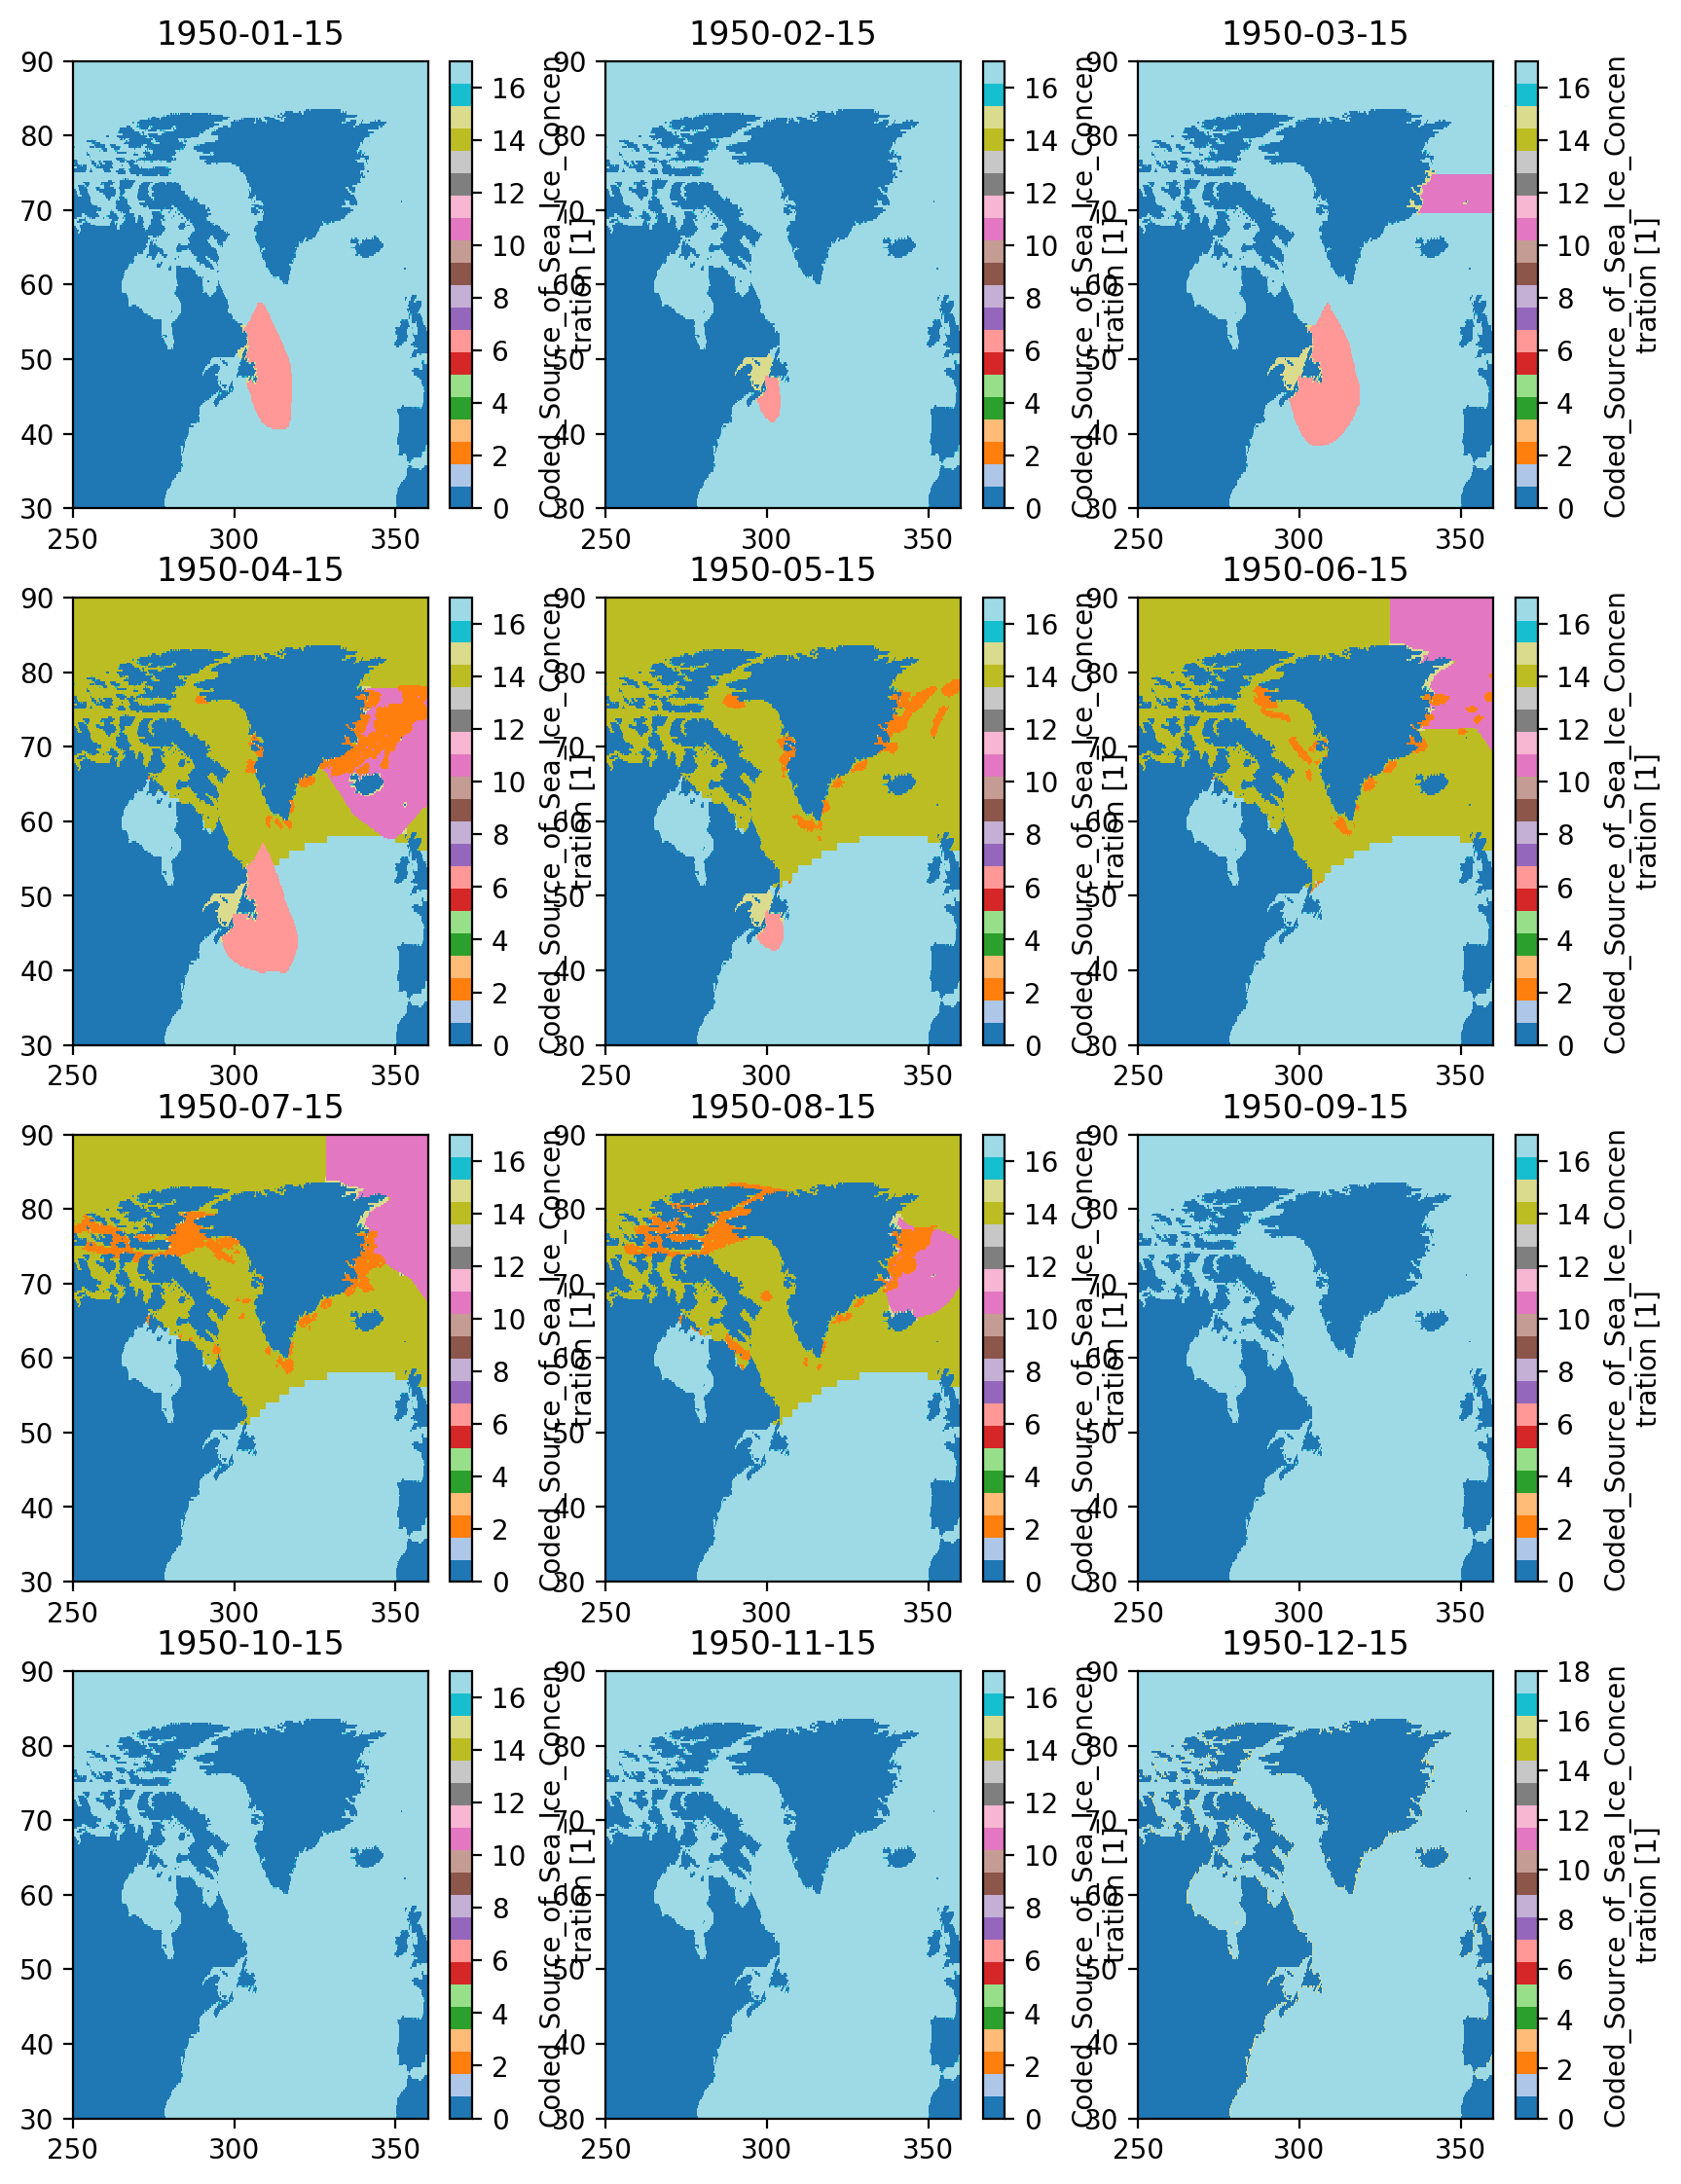

In [134]:
timez = ['1950-01-15','1950-02-15','1950-03-15','1950-04-15','1950-05-15','1950-06-15',
         '1950-07-15','1950-08-15','1950-09-15','1950-10-15','1950-11-15','1950-12-15']

fig,ax = plt.subplots(4,3, figsize=(10, 14))
ax = ax.flatten()

for i,t in enumerate(timez):
    walsh_sources_50_70 = walsh_ds.seaice_source.sel(time=slice('1950','1965'))
    walsh_sources_50_70.sel(time=t).plot(ax=ax[i],cmap='tab20', label='source')
    
    ax[i].set_title(t)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_xlim(250,360)

# plot_val = np.squeeze(walsh_sources_50_70.sel(time='1950-01-15').values)
# plt.pcolormesh(plot_val, cmap='tab20')


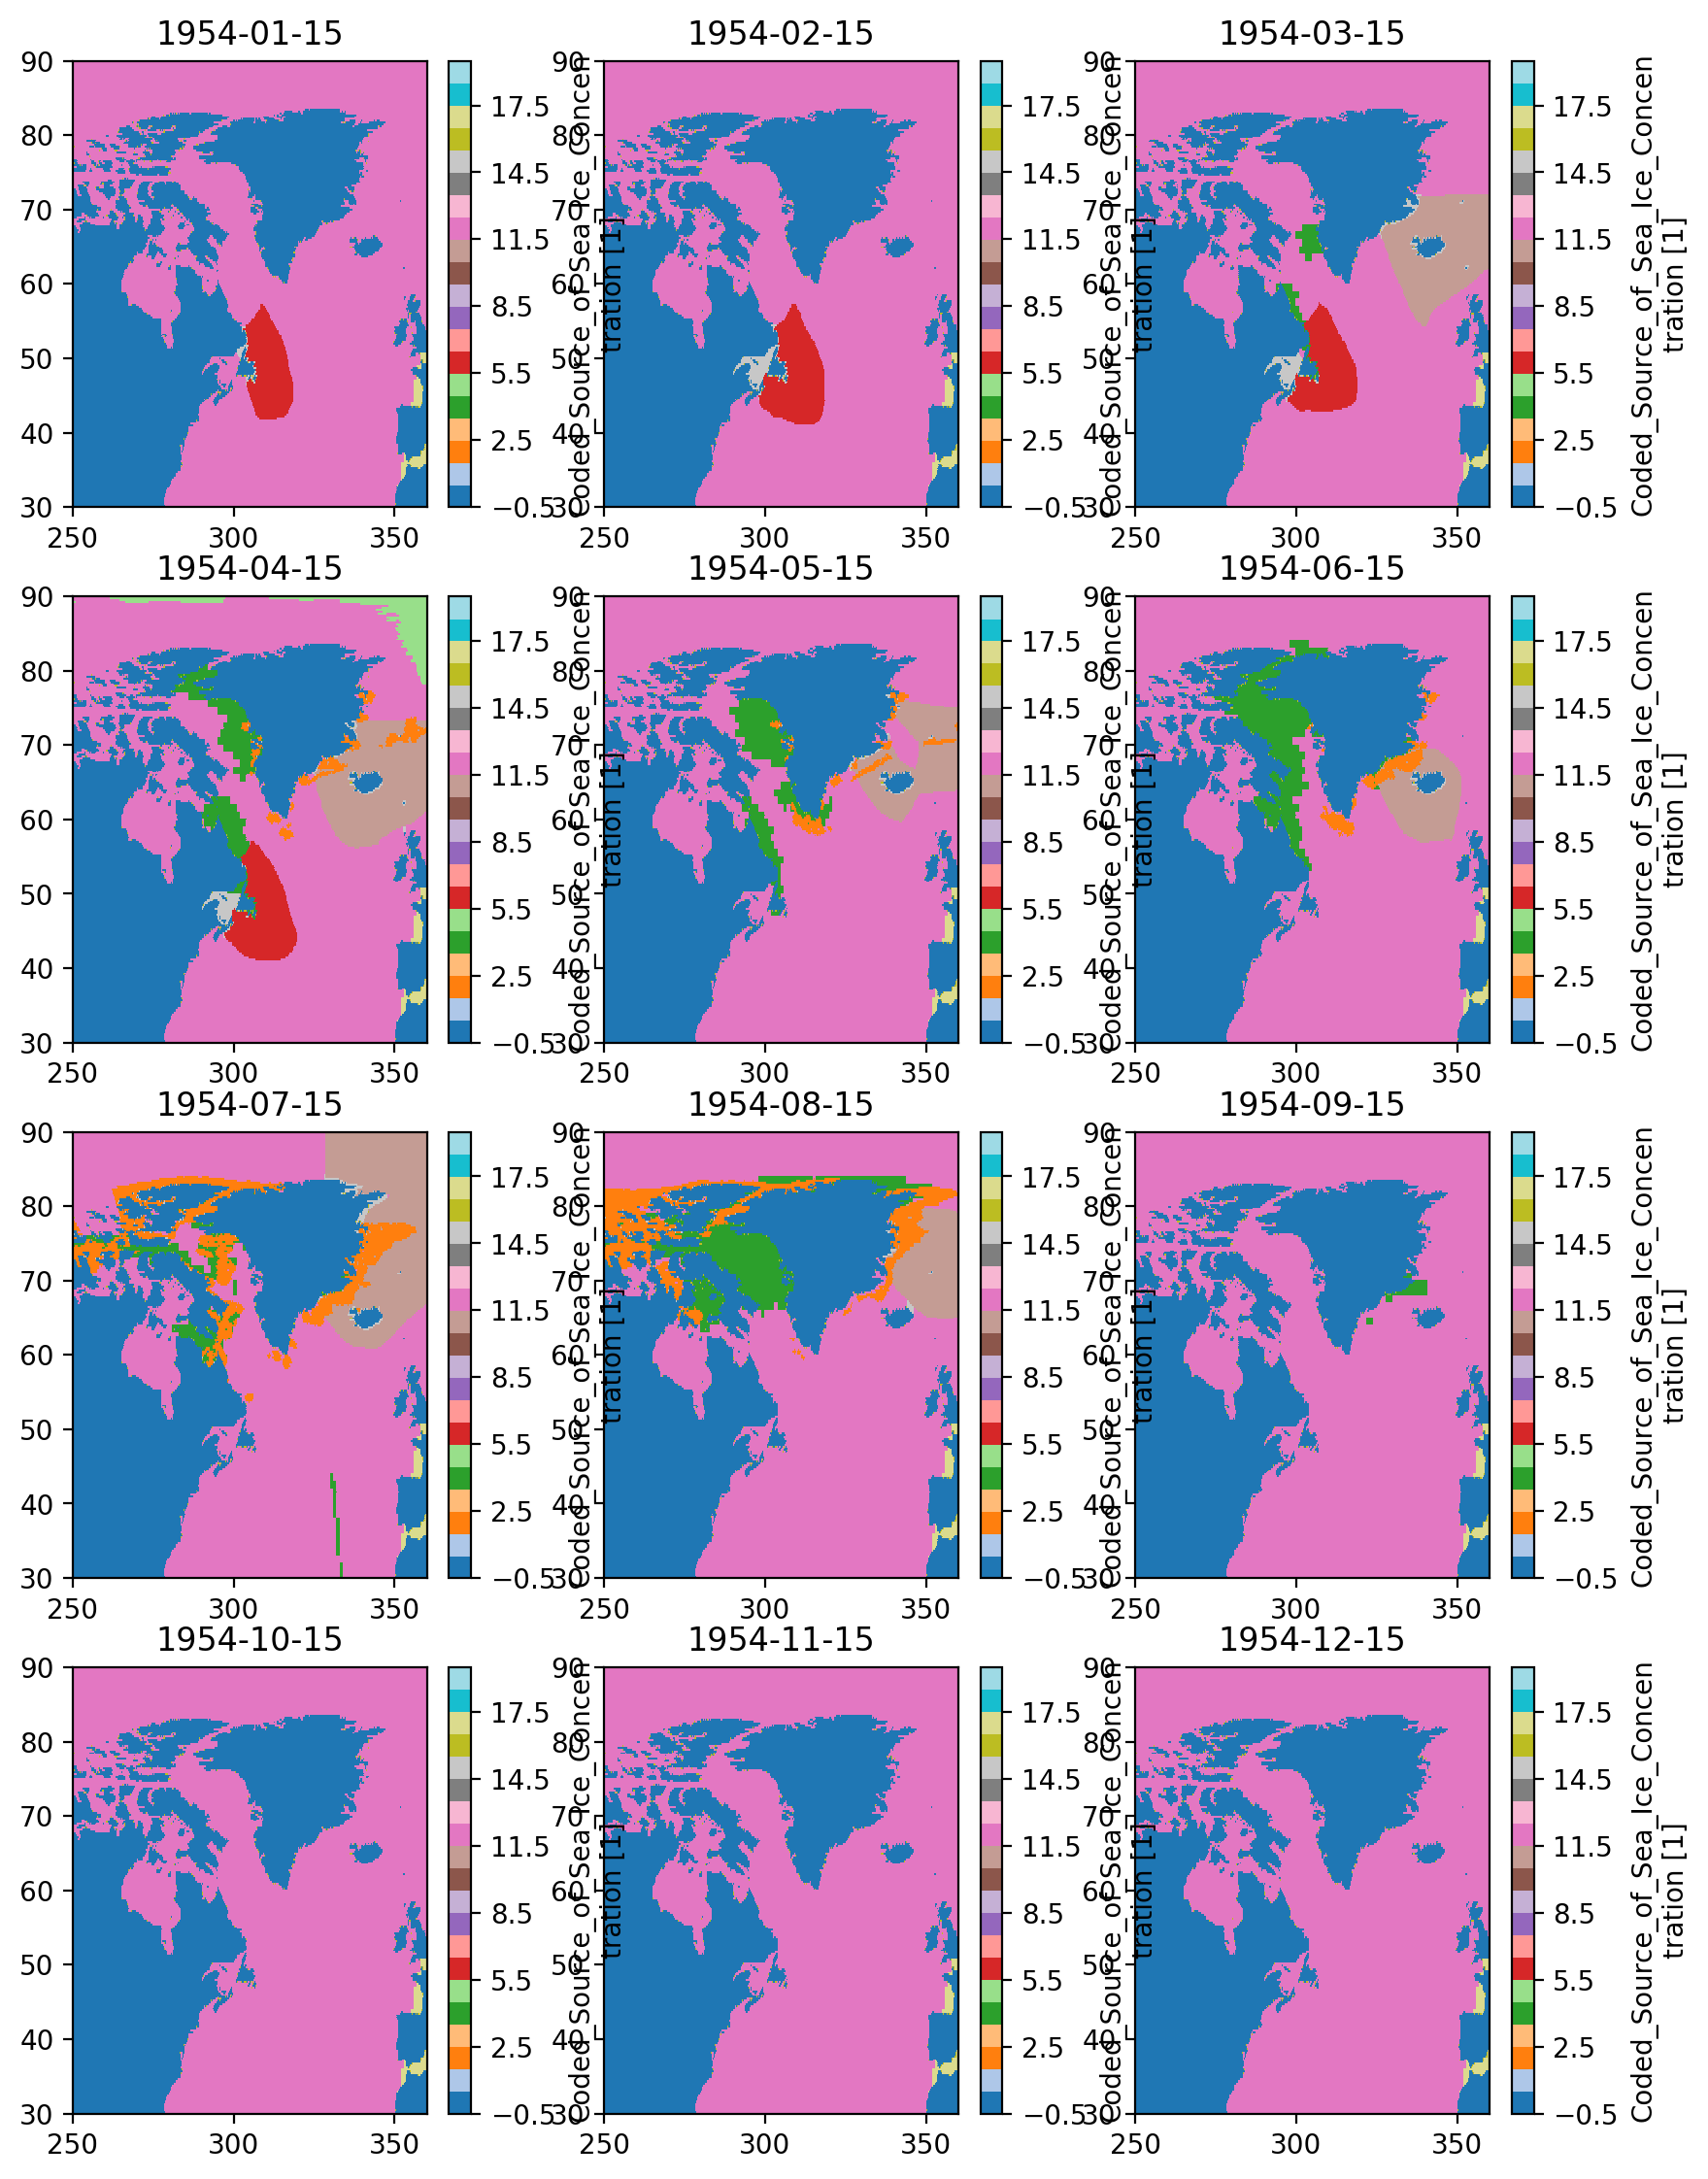

In [211]:
y = 1954

lev = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5,16.5,17.5,18.5,19.5]

timez = [str(y)+'-01-15',str(y)+'-02-15',str(y)+'-03-15',str(y)+'-04-15',str(y)+'-05-15',str(y)+'-06-15',
         str(y)+'-07-15',str(y)+'-08-15',str(y)+'-09-15',str(y)+'-10-15',str(y)+'-11-15',str(y)+'-12-15']

fig,ax = plt.subplots(4,3, figsize=(10, 14))
ax = ax.flatten()

for i,t in enumerate(timez):
    walsh_sources_50_70 = walsh_ds.seaice_source.sel(time=slice('1950','1965'))
    walsh_sources_50_70.sel(time=t).plot(ax=ax[i],cmap='tab20', label='source',levels=lev)
    
    ax[i].set_title(t)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_xlim(250,360)

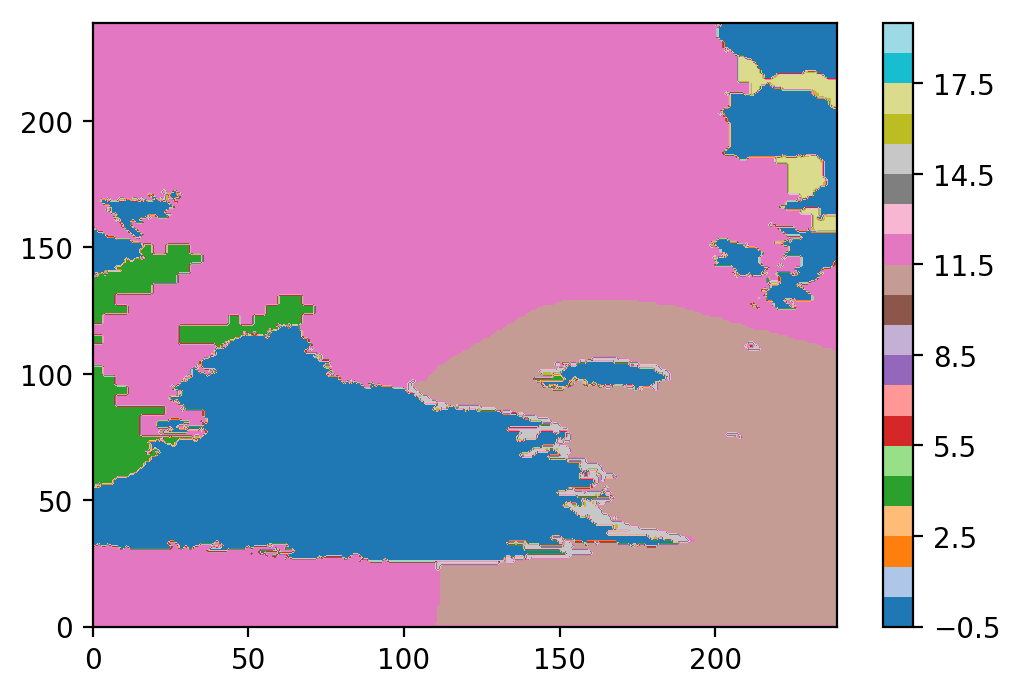

In [201]:
lev = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5,16.5,17.5,18.5,19.5]
lab = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]

plt.contourf(walsh_sources_50_70.sel(time='1958-05-15').values[0,:,1200:], cmap='tab20', levels=lev)

plt.colorbar()

In [199]:
walsh_sources_50_70.sel(time='1958-05-15').values[0,50:90,1200:1210]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 4,  4, 16,  0,  0,  0,  0,  0,  0,  0],
       [ 4,  4,  4,  4,  4,  4,  4,  0,  0,  0],
       [ 4,  4,  4,  4,  4,  4,  4,  0,  0,  0],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  0,  0],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 4,  4,  4, 

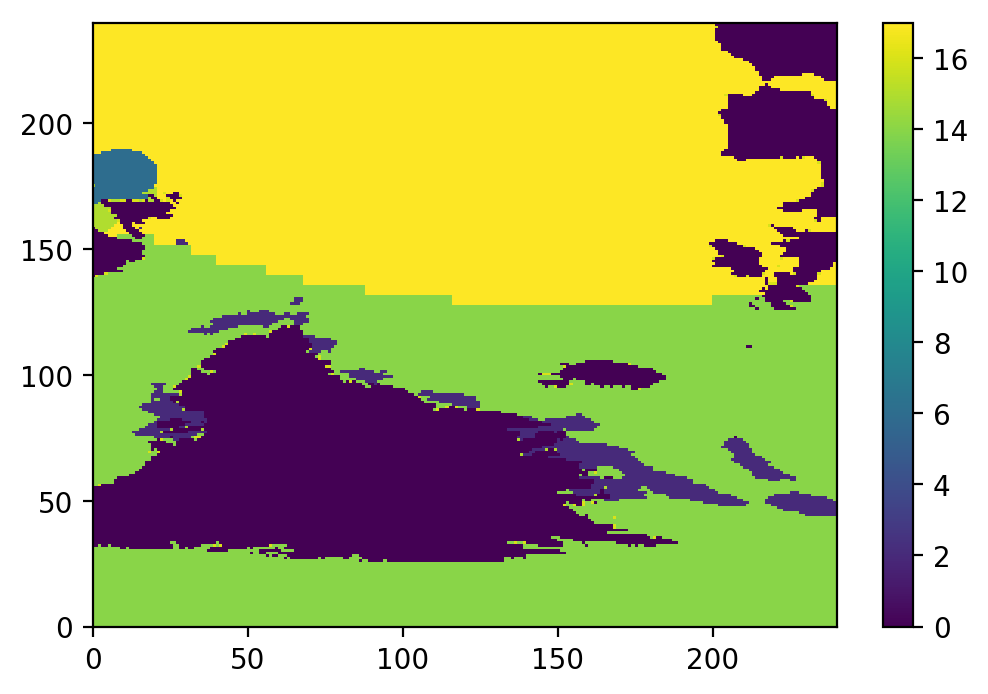

In [173]:
plt.pcolormesh(walsh_sources_50_70.sel(time='1950-05-15').values[0,:,1200:])
plt.colorbar()

In [187]:
walsh_sources_50_70.sel(time='1958-09-15').values[0,:,1200:]

array([[12, 12, 12, ..., 12, 12, 12],
       [12, 12, 12, ..., 12, 12, 12],
       [12, 12, 12, ..., 12, 12, 12],
       ...,
       [12, 12, 12, ...,  0,  0,  0],
       [12, 12, 12, ...,  0,  0,  0],
       [12, 12, 12, ...,  0,  0,  0]], dtype=uint8)